### 基础库导入

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from typing import Union
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
import joblib


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\BrainC\brainc_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\BrainC\brainc_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "d:\BrainC\brainc_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\BrainC\brainc_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\BrainC\brainc_env\lib\site-packages\ipykernel\kern

AttributeError: _ARRAY_API not found

### 路径定义

In [4]:
root = '.'
# raw_data_root = os.path.join(root, 'None')
data_folder = os.path.join(root, 'dataset')
fc_data_folder = os.path.join(data_folder, 'fc_data')
math_data_url = os.path.join(data_folder, 'math_data')
fc_residual_data_folder = os.path.join(data_folder, 'fc_residual_data')
projection_url = os.path.join(root, 'references', 'networks_projection.csv')
img_save_folder = os.path.join(root, 'imgs')
model_folder = os.path.join(root, 'models')

### 环境变量

In [5]:
dataset_tags = ['ant', 'bart', 'em', 'nb']
NODES_RANGE = range(1, 269)
NETWORKS = {1: 'Medial frontal', 2: 'Frontoparietal', 3: 'Default mode', 4: 'Subcortical-cerebellum', 5: 'Motor', 6: 'Visual I', 7: 'Visual Ⅱ', 8: 'Visual association'}
# 矩阵按照下三角组合的索引对，转为list如(e.g. [0-1, 0-2, ...])
LOWER_TRIANGULAR_IDX = [f'{i}-{j}' for i in range(1, 269) for j in range(i+1, 269)]
FC_KEYS = ['FC_mat']
MATH_KEYS = {'math': ['behav_math'], 'ID': ['cov_ID2'], 'gender': ['cov_gender'], 'grade': ['cov_grade'], 'motion':['cov_motion']}

In [6]:
# 获取映射关系
projection = pd.read_csv(projection_url)
projection.head()

Node  Network
0     1        2
1     2        4
2     3        3
3     4        2
4     5        3

### 函数定义

In [19]:
# # 从Excel数据中提取特定表数据
# def get_slice_fc(fc_bart:pd.DataFrame, slice:int):
#     """
#     Describe:
#         get fc of a slice from fc_bart.
#     Input:
#         fc_bart: pd.DataFrame
#         slice: int
#     Output:
#         sheet: pd.DataFrame
#     """
#     # get all sheet names
#     slice_names = fc_bart.sheet_names
#     slice_name = 'Slice_' + str(slice)
#     if slice_name not in slice_names:
#         raise ValueError(f'Slice not found, Slice from {slice_names[1]} to {slice_names[-1]}')
#     # get the sheet of the slice
#     sheet = fc_bart.parse(slice_name, header=None)
#     # set headers and idx like 'Voxel1'
#     sheet.columns = ['Voxel' + str(i) for i in range(1, sheet.shape[1] + 1)]
#     sheet.index = ['Voxel' + str(i) for i in range(1, sheet.shape[0] + 1)]
    
#     return sheet

In [20]:
# # 加载数据
# def load_data(data_path: str) -> pd.DataFrame:
#     if not os.path.exists(data_path):
#         raise FileNotFoundError(f"file not found: {data_path}")
    
#     if data_path.endswith(".csv"):
#         df = pd.read_csv(data_path)
#     elif data_path.endswith(".xlsx"):
#         df = pd.ExcelFile(data_path)
#         if len(df.sheet_names) == 1:
#             df = df.parse(df.sheet_names[0], header=None)
    
#     return df

In [21]:
# 获取指定目录下的所有文件名
def get_files(path: str, suffix: Union[str, list]=None) -> list:
    """
    Describe:
        get all files under the path with the specified suffix.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"file not found: {path}")
    
    if isinstance(suffix, str):
        suffix = [suffix]
    if suffix is None:
        suffix = []
    
    files = []
    for root, dirs, filenames in os.walk(path):
        for filename in filenames:
            if filename.split('.')[-1] in suffix:
                files.append(os.path.join(root, filename))

    return files

In [22]:
# 读取.mat数据
def load_mat(mat_path: str, *args) -> np.array:
    """
    Describe:
        load .mat file to numpy array.
    Input:
        mat_path: str
    Output:
        data: np.array
    """
    if not os.path.exists(mat_path):
        raise FileNotFoundError(f"file not found: {mat_path}")
    
    mat = loadmat(mat_path)

    # # 打印各个变量的维度
    # for key, value in mat.items():
    #     if isinstance(value, np.ndarray):
    #         print(f"{key}: {value.shape}")
    # return

    # transform to numpy array
    if len(args) == 1:
        data = mat[args[0]]
    elif len(args) > 1:
        data = {key:mat[key] for key in args}
    else:
        data = mat
    
    return data

In [23]:
# 将numpy array转为pandas DataFrame
def array2df(data: np.array, columns:list=None, 
idx:list=None) -> pd.DataFrame:
    """
    Describe:
        transform numpy array to pandas DataFrame.
    Input:
        data: np.array
        columns: list
        idx: list
    Output:
        df: pd.DataFrame
    """
    if isinstance(data, np.ndarray):
        # check dimensions
        if data.ndim > 2:
            raise ValueError(f"Data dimensions should be less than 3, but got {data.ndim}: {data.shape}")
        
        if columns:
            if len(columns) != data.shape[1]:
                raise ValueError(f"Columns length should be equal to data's second dimension{data.shape[1]}, but got {len(columns)}")
        if idx:
            if len(idx) != data.shape[0]:
                raise ValueError(f"Index length should be equal to data's first dimension{data.shape[0]}, but got {len(idx)}")
            
        df = pd.DataFrame(data, columns=columns, index=idx)
    else:
        raise TypeError(f"Data type should be np.ndarray, but got {type(data)}")
    
    return df

In [24]:
# 取对称矩阵的下三角元素并将元素展平为一维
def flatten_lower_triangle(matrix: np.array) -> np.array:
    """
    Describe:
        flatten lower triangle of a matrix.
    Input:
        matrix: np.array
    Output:
        flatten_matrix: np.array
    """
    if matrix.ndim != 2:
        raise ValueError(f"Matrix dimensions should be 2, but got {matrix.ndim}")
    
    # get lower triangle index
    idx = np.tril_indices(matrix.shape[0], -1)
    flatten_matrix = matrix[idx]
    
    return flatten_matrix

In [25]:
# 提取数据下三角元素并展平拼接
def merge_lower_triangle(data: np.array, pd_form=True) -> pd.DataFrame:
    """
    Describe:
        merge lower triangle of each matrix in data.
    Input:
        data: np.array
    Output:
        flatten_data: pd.DataFrame
    """
    if data.ndim != 3:
        raise ValueError(f"Data dimensions should be 3, but got {data.ndim}")
    
    # 将fc_bart下三角阵展平并合并
    for i in range(1, data.shape[2]):
        flatten = np.vstack([flatten_lower_triangle(data[:, :, i]) for i in range(data.shape[2])])
    if pd_form:
        flatten = array2df(flatten, columns=LOWER_TRIANGULAR_IDX)
    
    return flatten


In [26]:
# 提取数据下三角元素并展平拼接
def restore_symmetric_matrix(flatten_data: np.array, matrix_size: int) -> np.array:
    """
    Describe:
        Restore a symmetric matrix from flattened lower triangle elements.
    Input:
        flatten_data: np.array
        matrix_size: int
    Output:
        matrix: np.array
    """
    if len(flatten_data.shape) != 2:
        raise ValueError(f"Flatten data dimensions should be 2, but got {len(flatten_data.shape)}")
    
    if isinstance(flatten_data, pd.DataFrame):
        flatten_data = flatten_data.to_numpy()
    
    matrix = np.zeros((matrix_size, matrix_size, flatten_data.shape[0]))
    for i in range(flatten_data.shape[0]):
        if flatten_data.shape[1] != matrix_size * (matrix_size - 1) / 2:
            raise ValueError(f"Flatten data shape should be {matrix_size * (matrix_size - 1) / 2}, but got {flatten_data.shape[1]}")
        
        tril_indices = np.tril_indices(matrix_size, -1)

        matrix[:, :, i] = np.zeros((matrix_size, matrix_size))
        # 还原下三角元素
        for j in range(len(flatten_data[i])):
            matrix[tril_indices[0][j], tril_indices[1][j]] = flatten_data[i][j]
        matrix[:, :, i] = matrix[:, :, i] + matrix[:, :, i].T

        # 对角线元素设为1
        np.fill_diagonal(matrix[:, :, i], 1)

    return matrix

In [27]:
# 将对称的fc矩阵变为下三角阵，上三角阵置为0
def reset_fc_matrix(fc_matrix: Union[pd.DataFrame, np.ndarray]):
    """
    Describe:
        reset fc matrix to lower triangle matrix.
    Args:
        fc_matrix: pd.DataFrame or np.ndarray
    """
    if isinstance(fc_matrix, pd.DataFrame):
        # 处理DataFrame类型的fc_matrix
        pass
    elif isinstance(fc_matrix, np.ndarray):
        # 处理ndarray类型的fc_matrix
        pass
    n = fc_matrix.shape[0]
    new_fc_matrix = fc_matrix.copy()
    for i in range(n):
        for j in range(i+1, n):
            new_fc_matrix[j, i] = 0
    return pd.DataFrame(new_fc_matrix)

In [28]:
# 使用fsl绘制fc矩阵的热图
def plot_fc_heatmap(fc_matrix: Union[pd.DataFrame, np.ndarray], xlabel:str=None, ylabel:str=None, title:str='default', output:str=None):
    """
    Describe:
        plot fc matrix heatmap.
    Args:
        fc_matrix: pd.DataFrame or np.ndarray
        output: str
    """
    if isinstance(fc_matrix, pd.DataFrame):
        # 处理DataFrame类型的fc_matrix
        pass
    elif isinstance(fc_matrix, np.ndarray):
        # 处理ndarray类型的fc_matrix
        pass
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(fc_matrix, cmap='coolwarm', center=0, square=True)

    if xlabel:
        plt.xlabel(xlabel)
        plt.xticks([])
    if ylabel:
        plt.ylabel(ylabel)
        plt.yticks([])

    plt.title(title)

    if output:
        if not output.endswith('.png'):
            output += '.png'
        plt.savefig(output)
    # plt.close()

In [29]:
# node到network的映射方法
def node2network(projection_set:pd.DataFrame, nodes:list=None, networks:list=None, only_idx:bool=True, data:pd.DataFrame=None, flatten:bool=False)->Union[pd.DataFrame|tuple]:
    """
    Describe:
        node to network mapping.
        if set node, return the network of the node.
        if set n_networks, return the nodes of the network.
        if only_idx is True, only return the corresponding index of input.
        if data is set, return the corresponding data of the input with its shape.
    Args:
        projection_set: pd.DataFrame
        node: int
        n_networks: int
        only_idx: bool
        data: pd.DataFrame
        faltten: bool (whether data input is flatten)
    Returns:
        pd.DataFrame, tuple
    """
    if nodes is not None and networks is not None:
        raise ValueError("node and networks cannot be set at the same time.")
    
    if nodes is not None:
        if only_idx:
            unique_q = list(set(nodes))
            belongings = {}
            # 以network为key，node为value，构建字典
            for network in NETWORKS.keys():
                temp = projection_set[projection_set['Network'] == network]
                belongings[network] = temp[temp['Node'].isin(unique_q)]['Node'].unique()
            return belongings
        else:
            ...

    elif networks is not None:
        if only_idx:
            unique_q = list(set(networks))
            belongings = {}
            for network in unique_q:
                if network not in NETWORKS.keys():
                    raise ValueError(f"Network {network} not found.")
                belongings[network] = projection_set[projection_set['Network'] == network]['Node'].unique()
            return belongings
        else:
            ...
    

In [30]:
# 保存模型
def save_model(model, name_rule:str='model', sub_folder:str='', save_folder:str=model_folder):

    if not os.path.exists(save_folder):
        raise FileNotFoundError(f"folder not found: {save_folder}")
    
    if not os.path.exists(sub_folder) and sub_folder:
        os.makedirs(sub_folder)

    if isinstance(model, list):
        for i, m in enumerate(model):
            joblib.dump(m, os.path.join(save_folder, sub_folder, f'{name_rule}_{i+1}.pkl'))
    else:
        joblib.dump(model, os.path.join(save_folder, sub_folder, f'{name_rule}.pkl'))
    

### 数据概览

In [54]:
# get files
fc_files = get_files(fc_data_folder, 'mat')
math_files = get_files(math_data_url, 'mat')
fc_files, math_files

(['.\\dataset\\fc_data\\FC_ant.mat',
  '.\\dataset\\fc_data\\FC_bart.mat',
  '.\\dataset\\fc_data\\FC_em.mat',
  '.\\dataset\\fc_data\\FC_nb.mat'],
 ['.\\dataset\\math_data\\math_ant.mat',
  '.\\dataset\\math_data\\math_bart.mat',
  '.\\dataset\\math_data\\math_em.mat',
  '.\\dataset\\math_data\\math_nb.mat'])

In [55]:
# load data
fc_bart = load_mat(fc_files[1], *FC_KEYS)
math_scores = load_mat(math_files[1], *MATH_KEYS['math'])
fc_bart.shape, math_scores.shape

((268, 268, 300), (300, 1))

In [56]:
# transform to DataFrame
fc_bart0 = array2df(fc_bart[:, :, 0], columns=NODES_RANGE, idx=NODES_RANGE)
math_scores = array2df(math_scores, columns=['math'])
fc_bart0.head()

1         2         3         4         5         6         7    \
1  0.000000 -0.134212  0.173157  0.104981  0.085369 -0.054657  0.133306   
2 -0.134212  0.000000  0.227494  0.251627  0.069518  0.204896  0.208686   
3  0.173157  0.227494  0.000000  0.333182  0.233398  0.180528  0.144632   
4  0.104981  0.251627  0.333182  0.000000 -0.092764  0.081935  0.295651   
5  0.085369  0.069518  0.233398 -0.092764  0.000000  0.458606 -0.020393   

        8         9         10   ...       259       260       261       262  \
1  0.247122  0.367899 -0.064801  ...  0.237436  0.215343  0.051870  0.206197   
2  0.075589  0.084577  0.098416  ... -0.200088 -0.238993  0.178875  0.065824   
3 -0.049372  0.049068  0.097894  ...  0.047772 -0.157287  0.230667  0.126153   
4  0.226443  0.423303  0.002452  ... -0.044735  0.223942  0.115371  0.288373   
5  0.029129 -0.004345  0.703778  ...  0.385358 -0.099475  0.126898  0.239115   

        263       264       265       266       267       268  
1  0.196908  0.166484  0.243988  0.008609  0.478688 -0.100761  
2 -0.166461 -0.270812  0.143404 -0.011739 -0.296496  0.124123  
3 -0.095713 -0.417319  0.306749 -0.040966 -0.043232  0.016863  
4  0.365413  0.130634  0.269977  0.021065 -0.038831  0.345634  
5 -0.143319 -0.259855 -0.037367 -0.065286  0.226203  0.059890  

[5 rows x 268 columns]

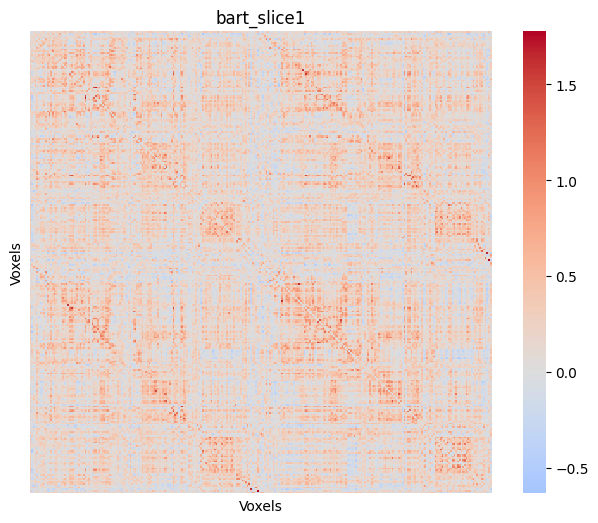

In [57]:
plot_fc_heatmap(fc_bart0, xlabel='Voxels', ylabel='Voxels', title='bart_slice1', output=os.path.join(img_save_folder, 'bart_slice1.png'))

In [58]:
math_scores.head()

math
0  558.50
1  510.24
2  558.50
3  393.82
4  477.30

In [59]:
math_scores.describe()

math
count  300.000000
mean   533.609833
std     99.473179
min    292.990000
25%    461.620000
50%    522.680000
75%    603.740000
max    795.010000

In [ ]:
# test of projection between node and network
results = node2network(
    projection_set=projection,
    nodes=None,
    networks=[1, 2, 3],
    only_idx=True,
    data=None,
    flatten=False
)
results

{1: array([ 10,  12,  16,  52,  53,  54,  56,  57,  64,  65, 137, 140, 145,
        148, 149, 150, 151, 153, 156, 162, 165, 183, 185, 186, 187, 190,
        192, 194, 219]),
 2: array([  1,   4,   7,   8,   9,  14,  17,  19,  21,  22,  30,  31,  47,
         48,  55,  70, 111, 112, 116, 139, 142, 143, 147, 154, 157, 164,
        182, 184, 193, 196, 199, 242, 246, 247]),
 3: array([  3,   5,   6,  13,  49,  50,  85,  86,  90,  96, 115, 134, 138,
        141, 203, 222, 223, 225, 227, 239])}

### GAT

Idea:  FC矩阵->残差回归->GAT模型对数学成绩进行分类（数学成绩按照上下四分位数分层）

#### 库导入

In [31]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tqdm.notebook import tqdm
from copy import deepcopy
from sklearn.linear_model import ElasticNet
from typing import Literal
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor

import torch_geometric
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.preprocessing import OneHotEncoder

In [32]:
import torch
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

2.5.1+cu124
Using cuda


#### Methods

In [33]:
# 弹性网络残差回归
def elastic_network_regress_out_covariates(data: np.array, *covariates) -> pd.DataFrame:
    """
    Describe:
        Regress out covariates from data using ElasticNet regression.
    Input:
        data: np.array
        covariates: np.array
    Output:
        residuals: pd.DataFrame
    """

    # 将fc_bart下三角阵展平并合并
    lower_triangle_fc = merge_lower_triangle(data)
    
    # 合并协变量
    cov = np.stack([covariate for covariate in covariates], axis=1).squeeze(-1)
    cov = array2df(cov, columns=list(MATH_KEYS.keys())[2:2+len(covariates)])
    print(lower_triangle_fc.shape, cov.shape)

    residuals = pd.DataFrame(index=lower_triangle_fc.index, columns=lower_triangle_fc.columns)
    r2_scores = []
    
    # 遍历每个下三角元素
    for column in lower_triangle_fc.columns:
        y = lower_triangle_fc[column]
        X = cov
        
        # 使用弹性网络回归模型
        model = ElasticNet()
        model.fit(X, y)
        y_pred = model.predict(X)
        residuals[column] = y - y_pred

        # 计算评价指标
        r2_scores.append(r2_score(y, y_pred))

    print(f"R²: {np.mean(r2_scores):.4f}")

    return residuals

In [34]:
def regress_out_covariates(data: np.array, *covariates) -> pd.DataFrame:
    """
    Describe:
        regress out covariates from data.
    Input:
        data: np.array
        covariates: np.array
    Output:
        residuals: pd.DataFrame
    """

    # 将fc_bart下三角阵展平并合并
    lower_triangle_fc = merge_lower_triangle(data)
    
    # 合并协变量
    cov = np.stack([covariate for covariate in covariates], axis=1).squeeze(-1)
    cov = array2df(cov, columns=list(MATH_KEYS.keys())[2:2+len(covariates)])
    print(lower_triangle_fc.shape, cov.shape)

    residuals = pd.DataFrame(index=lower_triangle_fc.index, columns=lower_triangle_fc.columns)
    r2_scores = []
    # 遍历每个下三角元素
    for column in lower_triangle_fc.columns:
        y = lower_triangle_fc[column]
        X = sm.add_constant(cov)
        model = sm.OLS(y, X).fit()
        residuals[column] = model.resid

        # 计算评价指标
        r2_scores.append(model.rsquared)

    print(f"R²: {np.mean(r2_scores):.4f}")

    return residuals

In [35]:
# 将数据集划分为训练集和测试集
def split_data(data, labels, test_size=0.2, random_state=42, flatten=True):
    
    if data.ndim == 3 and isinstance(data, np.ndarray):
        data = merge_lower_triangle(data)
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)

        if not flatten:
            X_train_numpy = np.zeros((len(NODES_RANGE), len(NODES_RANGE), X_train.shape[0]))
            X_test_numpy = np.zeros((len(NODES_RANGE), len(NODES_RANGE), X_test.shape[0]))
            for i in range(X_train.shape[0]):
                X_train_numpy[:, :, i] = restore_symmetric_matrix(X_train[i], len(NODES_RANGE))
            for i in range(X_test.shape[0]):
                X_test_numpy[:, :, i] = restore_symmetric_matrix(X_test[i], len(NODES_RANGE))

    else:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test

In [36]:
# 数据标准化
def standardize_data(train_data: Union[pd.DataFrame|np.ndarray|None], test_data: None, method: Literal['z-score', 'min-max']='z-score') -> np.array:
    """
    Describe:
        standardize data.
    Input:
        train_data: pd.DataFrame or np.array
        test_data: pd.DataFrame or np.array
        method: str
    Output:
        train_standardized: pd.DataFrame
        test_standardized: pd.DataFrame
    """
    
    if method == 'z-score':
        mean = np.mean(train_data, axis=0)
        std = np.std(train_data, axis=0)
        train_standardized = (train_data - mean) / std
        if test_data is not None:
            test_standardized = (test_data - mean) / std
        else:
            test_standardized = None
    elif method == 'min-max':
        min_val = np.min(train_data, axis=0)
        max_val = np.max(train_data, axis=0)
        train_standardized = (train_data - min_val) / (max_val - min_val)
        if test_data is not None:
            test_standardized = (test_data - min_val) / (max_val - min_val)
        else:
            test_standardized = None
    else:
        raise ValueError(f"Invalid method: {method}")
    
    return train_standardized, test_standardized

In [37]:
# PCA降维
def pca_reduction(data, n_components=0.95, model:Literal['fit_transform', 'transform']='fit', pca=None):
    if isinstance(data, np.ndarray) and data.ndim == 3:
        # flatten lower triangle
        data = merge_lower_triangle(data)
         
        pca = PCA(n_components=n_components)
        if model == 'fit_transform':
            data = pca.fit_transform(data)
            # 添加列名
            columns = [f'PC{i+1}' for i in range(data.shape[1])]
            data = pd.DataFrame(data, columns=columns)
            # 打印降维后数据维度与方差贡献率
            print(f"Data shape after PCA: {data.shape}")
            print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
            
            return data, pca

        elif model == 'transform':
            if pca is None:
                raise ValueError("PCA model should be set when model is 'transform'")

            data = pca.transform(data)
            # 添加列名
            columns = [f'PC{i+1}' for i in range(data.shape[1])]
            data = pd.DataFrame(data, columns=columns)

            return data
        
    elif isinstance(data, pd.DataFrame) and data.ndim == 2:
        if model == 'fit_transform':
            pca = PCA(n_components=n_components)
            data = pca.fit_transform(data)
            # 添加列名
            columns = [f'PC{i+1}' for i in range(data.shape[1])]
            data = pd.DataFrame(data, columns=columns)
            # 打印降维后数据维度与方差贡献率
            print(f"Data shape after PCA: {data.shape}")
            print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

            return data, pca

        elif model == 'transform':
            if pca is None:
                raise ValueError("PCA model should be set when model is 'transform'")

            data = pca.transform(data)
            # 添加列名
            columns = [f'PC{i+1}' for i in range(data.shape[1])]
            data = pd.DataFrame(data, columns=columns)

            return data
    else:
        raise ValueError("Data should be 2D(pd.Dataframe) or 3D(numpy) array.")


In [38]:
# 模型训练框架
def train_model(model, train_dataloader, test_dataloader, optimizer, epochs=100, criterion=nn.MSELoss(), metrics=['mse', 'person', 'r2'], device='cuda'):
    """
    Describe:
        train model.
    Args:
        model: nn.Module
        train_dataloader: DataLoader
        test_dataloader: DataLoader
        optimizer: torch.optim
        epochs: int
        metrics: list
    Returns:
        model: nn.Module
    """
    if device == 'cuda' and not torch.cuda.is_available():
        device = 'cpu'
    model = model.to(device)  

    criterion = criterion
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, y in train_dataloader:
            data = data.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        
        model.eval()
        test_loss = 0
        y_true = []
        y_pred = []
        for data, y in test_dataloader:
            data = data.to(device)
            y = y.to(device)
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, y)
                test_loss += loss.item()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(output.cpu().numpy())
        test_loss /= len(test_dataloader)
        
        if 'mse' in metrics:
            mse = mean_squared_error(y_true, y_pred)
        if 'person' in metrics:
            person = pearsonr(y_true, y_pred)[0][0]
        if 'r2' in metrics:
            r2 = r2_score(y_true, y_pred)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, MSE: {mse:.4f}, Person: {person:.4f}, R²: {r2:.4f}")
    
    return model

In [54]:
# 搜惨
def hyper_tuning(train_dataset, test_dataset, model, hidden_size, droupout_rate, epochs, lr, weight_decay, optimizer, criterion, params, cv=3, device='cuda', verbose=1):

    # 将数据传输到GPU
    X_train = torch.tensor(train_dataset.data.to_numpy(), dtype=torch.float32).cuda()
    y_train = torch.tensor(train_dataset.labels, dtype=torch.float32).cuda()
    X_test = torch.tensor(test_dataset.data.to_numpy(), dtype=torch.float32).cuda()
    y_test = torch.tensor(test_dataset.labels, dtype=torch.float32).cuda()
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # 合并
    X = torch.cat((X_train, X_test), dim=0)
    y = torch.cat((y_train, y_test), dim=0)

    # 创建skorch的NeuralNetRegressor
    net = NeuralNetRegressor(
        module=model,
        module__input_size=X_train.shape[1],
        module__hidden_size=hidden_size,
        module__output_size=y_train.shape[1],
        module__dropout_rate=droupout_rate,
        max_epochs=epochs,
        lr=lr,
        optimizer__weight_decay=weight_decay,
        optimizer=optimizer,
        criterion=criterion,
        device=device,  # 指定设备为CUDA
        verbose=verbose
    )
    
    # 创建网格搜索
    grid = GridSearchCV(estimator=net, param_grid=params, n_jobs=1, cv=cv, scoring='r2')

    # 进行网格搜索
    grid_result = grid.fit(X, y)

    # 输出最佳参数和最佳得分
    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

    # 使用最佳参数训练模型
    best_model = grid_result.best_estimator_
    best_model.fit(X_train, y_train)

    # 评估模型
    loss = best_model.score(X_test, y_test)
    print(f"Test loss: {loss}")

    return best_model, grid_result, loss

#### Pipline

##### 加载原始数据

In [40]:
# 读取数据
fc_files = get_files(fc_data_folder, 'mat')
math_files = get_files(math_data_url, 'mat')
fc_files, math_files

(['.\\dataset\\fc_data\\FC_ant.mat',
  '.\\dataset\\fc_data\\FC_bart.mat',
  '.\\dataset\\fc_data\\FC_em.mat',
  '.\\dataset\\fc_data\\FC_nb.mat'],
 ['.\\dataset\\math_data\\math_ant.mat',
  '.\\dataset\\math_data\\math_bart.mat',
  '.\\dataset\\math_data\\math_em.mat',
  '.\\dataset\\math_data\\math_nb.mat'])

In [41]:
# fc_ant = load_mat(fc_files[0], *FC_KEYS)
# fc_bart = load_mat(fc_files[1], *FC_KEYS)
# fc_em = load_mat(fc_files[2], *FC_KEYS)
# fc_nb = load_mat(fc_files[3], *FC_KEYS)
# math_ant = load_mat(math_files[0])
# math_bart = load_mat(math_files[1])
# math_em = load_mat(math_files[2])
# math_nb = load_mat(math_files[3])

# gender_bart = load_mat(math_files[1], *MATH_KEYS['gender'])
# grade_bart = load_mat(math_files[1], *MATH_KEYS['grade'])
# motion_bart = load_mat(math_files[1], *MATH_KEYS['motion'])
# fc_bart.shape, math_bart[MATH_KEYS['math'][0]].shape, gender_bart.shape, grade_bart.shape, motion_bart.shape

In [42]:
# np.unique(gender_bart), np.unique(grade_bart)

##### 年龄&性别的残差回归

In [155]:
ant_residuals = elastic_network_regress_out_covariates(
    fc_ant,
    math_ant[MATH_KEYS['gender'][0]], 
    math_ant[MATH_KEYS['grade'][0]]
    )
ant_residuals.shape

(256, 35778) (256, 2)
R²: 0.0000


(256, 35778)

In [164]:
bart_residuals = regress_out_covariates(
    fc_bart,
    math_bart[MATH_KEYS['gender'][0]],
    math_bart[MATH_KEYS['grade'][0]],
    math_bart[MATH_KEYS['motion'][0]]
    )
bart_residuals.shape

(300, 35778) (300, 3)
R²: 0.0253


(300, 35778)

In [165]:
em_residuals = regress_out_covariates(
    fc_em,
    math_em[MATH_KEYS['gender'][0]],
    math_em[MATH_KEYS['grade'][0]],
    math_em[MATH_KEYS['motion'][0]]
    )
em_residuals.shape

(306, 35778) (306, 3)
R²: 0.0260


(306, 35778)

In [166]:
nb_residuals = regress_out_covariates(
    fc_nb,
    math_nb[MATH_KEYS['gender'][0]],
    math_nb[MATH_KEYS['grade'][0]],
    math_nb[MATH_KEYS['motion'][0]]
    )
nb_residuals.shape

(309, 35778) (309, 3)
R²: 0.0486


(309, 35778)

In [75]:
# 保存
ant_residuals.to_csv(os.path.join(fc_residual_data_folder, 'ant_residuals.csv'))
bart_residuals.to_csv(os.path.join(fc_residual_data_folder, 'bart_residuals.csv'))
em_residuals.to_csv(os.path.join(fc_residual_data_folder, 'em_residuals.csv'))
nb_residuals.to_csv(os.path.join(fc_residual_data_folder, 'nb_residuals.csv'))

##### 加载残差回归数据

暂时使用bart进行测试

In [206]:
math_files = get_files(math_data_url, 'mat')

In [222]:
# 加载残差回归数据
bart_residuals = pd.read_csv(os.path.join(fc_residual_data_folder, 'bart_residuals.csv'), index_col=0)
math_bart = load_mat(math_files[1], *MATH_KEYS['math'])
# 标准化
scaled_bart_residuals = (bart_residuals - bart_residuals.mean()) / bart_residuals.std()
# 还原对称矩阵
restored_bart_residuals = restore_symmetric_matrix(scaled_bart_residuals, 268)
scaled_bart_residuals.shape, restored_bart_residuals.shape

((300, 35778), (268, 268, 300))

In [88]:
# 统计restored_ant_residuals中不为0的元素个数
np.count_nonzero(restored_bart_residuals[0])

80400

In [89]:
restored_bart_residuals.shape, math_bart.shape

((268, 268, 300), (300, 1))

##### 数据集划分

In [43]:
class Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if isinstance(self.data, pd.DataFrame):
            return torch.tensor(self.data.iloc[idx].values, dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)
        if isinstance(self.data, np.ndarray):
            return torch.tensor(self.data[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)

In [44]:
train_dataset = {}
test_dataset = {}

for i in tqdm(range(len(dataset_tags))):
    fc_data = load_mat(fc_files[i], *FC_KEYS)
    math_data = load_mat(math_files[i], *MATH_KEYS['math'])
    # 数据集划分
    X_train, X_test, y_train, y_test = split_data(
        fc_data, 
        math_data,
        test_size=0.2, 
        random_state=1, 
        flatten=True
        )
    # 数据标准化
    X_train, X_test = standardize_data(X_train, X_test)
    # labels 标准化
    y_train, y_test = standardize_data(y_train, y_test)
    
    # 创建数据集
    train_dataset[dataset_tags[i]] = Dataset(X_train, y_train)
    test_dataset[dataset_tags[i]] = Dataset(X_test, y_test)
print(train_dataset.keys(), test_dataset.keys())

  0%|          | 0/4 [00:00<?, ?it/s]

X_train shape: (204, 35778), X_test shape: (52, 35778), y_train shape: (204, 1), y_test shape: (52, 1)
X_train shape: (240, 35778), X_test shape: (60, 35778), y_train shape: (240, 1), y_test shape: (60, 1)
X_train shape: (244, 35778), X_test shape: (62, 35778), y_train shape: (244, 1), y_test shape: (62, 1)
X_train shape: (247, 35778), X_test shape: (62, 35778), y_train shape: (247, 1), y_test shape: (62, 1)
dict_keys(['ant', 'bart', 'em', 'nb']) dict_keys(['ant', 'bart', 'em', 'nb'])


In [45]:
train_dataset['bart'].data

1-2       1-3       1-4       1-5       1-6       1-7       1-8  \
158 -0.971850 -0.899264 -0.888381 -0.592260 -0.494866 -0.457413 -0.490479   
150  0.348340 -0.682910  0.323566 -0.035155  0.182183  0.046464 -1.055036   
102 -0.262883  0.821025 -1.739293  1.508314 -1.045600  0.173100  2.151931   
163  1.329060  1.418028  0.015900  0.615064  1.165643  0.137888  2.151876   
112  0.406249  0.616469  1.393260  1.319270  1.152164  0.825950 -0.286030   
..        ...       ...       ...       ...       ...       ...       ...   
203 -0.896477 -1.293920 -0.933261 -1.403312 -1.154408  0.203798 -0.963109   
255  0.484291 -0.039768  0.415087  0.003330  0.028356 -0.321632  0.128035   
72  -0.188683  0.327272  0.007336 -1.299887  0.549481 -1.216477 -0.011538   
235  0.154454  1.138003 -0.595819  1.169396  0.267930  0.700285  1.281466   
37   1.315189  0.698664  0.695590  0.636100  0.158111  0.226646  0.965646   

          1-9      1-10      1-11  ...   264-265   264-266   264-267  \
158 -0.375915  1.344885  0.465096  ... -0.068613 -1.340121  0.445082   
150  0.357270 -0.328299 -1.028515  ...  0.435461  1.062142  0.045514   
102 -0.250675  1.489236  1.685238  ...  0.545603  0.030392  0.419637   
163  0.317969  1.086419  0.443088  ...  0.039527  0.759887  0.508789   
112  1.016840 -0.873395  0.008160  ...  0.856466 -0.058598  0.346960   
..        ...       ...       ...  ...       ...       ...       ...   
203 -0.101742  0.273346  0.275581  ...  0.461916 -0.596887  1.411429   
255  0.691663  1.525334 -0.206404  ... -0.967177  1.369348 -0.051566   
72   0.198507  0.847165 -0.752437  ...  1.942008  1.334230 -2.745185   
235  0.069964  1.734455  1.588904  ...  0.126587  0.585387  0.234562   
37   1.096572 -0.972389  0.194944  ...  1.090567 -0.258264  1.639517   

      264-268   265-266   265-267   265-268   266-267   266-268   267-268  
158 -1.124697 -1.134092  1.367646  0.114185 -0.569811  1.190527  1.721631  
150  0.652346 -0.056266  0.429641  0.009979  0.166246  0.345823  1.454170  
102  0.265539  0.405831  0.188135 -0.045494 -0.160049 -1.241852 -2.584226  
163 -0.782504  0.570175  1.062634  1.671681  0.330172  0.040070  0.222288  
112 -0.194811 -1.021737 -0.024042  0.055209 -1.257885 -0.993472 -0.270585  
..        ...       ...       ...       ...       ...       ...       ...  
203  0.943726  0.068644  0.807855  0.099064 -0.048088 -0.601917 -0.264874  
255  0.106146 -0.479877 -1.217523  1.157876  1.104887 -0.763670 -0.810617  
72   0.301002  0.190075 -0.714930 -0.461454  0.140950  0.424951 -0.536931  
235  0.434196 -1.757975 -0.610816 -0.233627 -0.968361 -1.172863 -0.840407  
37   0.092614 -0.551995  1.317339  0.492668 -1.178271 -0.283431 -0.115948  

[240 rows x 35778 columns]

In [46]:
train_dataset['bart'].labels

array([[ 0.69003462],
       [-0.70836346],
       [-0.32529432],
       [-0.70836346],
       [-1.72389311],
       [ 0.56077262],
       [ 1.633306  ],
       [-0.89272238],
       [-0.41551678],
       [-1.49256631],
       [ 0.90660868],
       [-0.70836346],
       [-0.89272238],
       [-1.08079458],
       [-0.73626318],
       [-1.97649595],
       [-1.62754876],
       [-0.57890074],
       [-0.32529432],
       [ 0.28217687],
       [-0.32529432],
       [ 0.56077262],
       [ 0.08015482],
       [ 1.13683153],
       [ 0.90660868],
       [ 0.39498005],
       [ 0.28217687],
       [ 0.07844872],
       [ 2.14403141],
       [-0.41551678],
       [-0.12347298],
       [ 0.28217687],
       [-0.89272238],
       [ 0.28217687],
       [-0.2483192 ],
       [-0.89272238],
       [-1.22631469],
       [ 0.08015482],
       [-1.05289486],
       [-0.12347298],
       [ 1.53886847],
       [ 1.38030173],
       [ 0.73670141],
       [ 1.633306  ],
       [-0.70836346],
       [-1

##### PCA降维

In [47]:
# 对dataset_tags中的数据集进行PCA降维
pca_train_dataset = {}
pca_test_dataset = {}

for i in tqdm(range(len(dataset_tags))):
    # PCA降维
    X_train, pca_train = pca_reduction(
        train_dataset[dataset_tags[i]].data,
        model='fit_transform', 
        n_components=0.95)
    X_test = pca_reduction(
        test_dataset[dataset_tags[i]].data, 
        model='transform', 
        n_components=0.95, 
        pca=pca_train)
    
    # 创建数据集
    pca_train_dataset[dataset_tags[i]] = Dataset(X_train, train_dataset[dataset_tags[i]].labels)
    pca_test_dataset[dataset_tags[i]] = Dataset(X_test, test_dataset[dataset_tags[i]].labels)
print(pca_train_dataset.keys(), pca_test_dataset.keys())

  0%|          | 0/4 [00:00<?, ?it/s]

Data shape after PCA: (204, 175)
Explained variance ratio: [0.13165181 0.04506562 0.03363132 0.02271894 0.0213252  0.01548508
 0.01302424 0.01235928 0.01123089 0.01106108 0.01066603 0.01034302
 0.00974947 0.00936115 0.00899026 0.00890097 0.0085499  0.00808639
 0.00790996 0.00766932 0.00761693 0.00755874 0.00720552 0.00708851
 0.00681408 0.00676145 0.00672003 0.00656284 0.00637762 0.00626529
 0.00622429 0.00615403 0.00602407 0.00592053 0.00575295 0.00566155
 0.00546364 0.0054097  0.00537203 0.00533016 0.00522469 0.005136
 0.00504053 0.00501056 0.00496748 0.00492845 0.00487652 0.00476572
 0.00475048 0.00465683 0.00461842 0.0045033  0.00446981 0.00443256
 0.00439493 0.00435715 0.00430953 0.00428834 0.00423927 0.00421947
 0.00416308 0.00413514 0.00410094 0.00402247 0.00399367 0.00395366
 0.00391397 0.00389291 0.00385362 0.00382862 0.00381302 0.00375827
 0.00372535 0.00370818 0.00367603 0.00363977 0.00362346 0.00357157
 0.00352814 0.00351505 0.00350598 0.00347976 0.00345679 0.00343686
 0.00

In [48]:
pca_train_dataset[dataset_tags[0]].data.head()

PC1        PC2        PC3        PC4        PC5        PC6  \
0 -79.196661  -8.902582  17.769063  -1.329969  17.384645 -16.658025   
1  42.577937 -28.074483  16.132609  53.050732 -38.628946 -59.740590   
2  37.063061 -31.344697 -15.798337 -31.769530  -4.103202  13.062644   
3 -83.016301 -13.444085   9.418650 -10.787338 -13.951450  16.322468   
4 -45.869429 -15.350966  16.885803  28.398956   2.290089 -26.869158   

         PC7        PC8        PC9       PC10  ...      PC166      PC167  \
0 -12.257201 -10.710683  10.534978   6.010683  ...   0.962648  -6.293687   
1  21.638820  -9.534149  12.502288   2.401522  ...  -6.374710 -10.240094   
2 -32.210548  -1.684316  37.889559 -21.168216  ...   6.955181   0.176190   
3  -5.354881  -6.627529  -8.238282  -0.877478  ...  10.891021  -2.873767   
4   6.675778  -6.615726  -0.952996   9.372990  ...  22.432759 -12.308549   

       PC168      PC169      PC170      PC171      PC172     PC173      PC174  \
0  17.477879   9.039837   0.426310  -5.279155 -10.270431 -8.093279   9.169858   
1 -15.305026  -7.069429  13.061610 -14.638247  -1.354126 -0.624302   3.721166   
2  -2.344835   7.231520  -0.138127   6.525578  -4.232019  3.193110   4.843483   
3  10.310862   7.541688  10.758517   4.540739   6.454150 -0.746457  23.526009   
4   1.637306  15.439188  -4.541132  -4.708143 -10.708685 -1.588745   4.874342   

       PC175  
0   4.273503  
1  -0.991943  
2 -10.047882  
3   3.923331  
4   7.360116  

[5 rows x 175 columns]

##### Autoencoder降维

##### MLP

In [49]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.fc2 = nn.Linear(in_features, in_features)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        out += residual
        out = F.relu(out)
        return out

class FourLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(FourLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.res_block1 = ResidualBlock(hidden_size)
        self.res_block2 = ResidualBlock(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout层
        self.bn = nn.BatchNorm1d(hidden_size) # 标准化
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # 应用Dropout
        x = self.res_block1(x)
        x = self.bn(x)
        x = self.dropout(x)  # 应用Dropout
        x = self.res_block2(x)
        # x =self.bn(x)
        x = self.fc2(x)
        return x

In [ ]:
# 搜参
params = {
        'module__hidden_size': [32, 64, 128, 256],
        'module__dropout_rate': [0.0, 0.2, 0.5],
        'lr': [0.001, 0.01, 0.1],
        'max_epochs': [400],
        'batch_size': [16, 32, 64]
    }

model = FourLayerMLP
hidden_size = 128
droupout_rate = 0.5
epochs = 400
lr = 0.001
weight_decay = 0.01
optimizer = optim.Adam
criterion = nn.MSELoss

best_model, grid_result, loss = hyper_tuning(
    pca_train_dataset['bart'], 
    pca_test_dataset['bart'], 
    model, 
    hidden_size, 
    droupout_rate, 
    epochs, 
    lr, 
    weight_decay, 
    optimizer, 
    criterion, 
    params, 
    cv=3, 
    device='cuda', 
    verbose=1
    )

torch.Size([240, 209]) torch.Size([240, 1]) torch.Size([60, 209]) torch.Size([60, 1])
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.5098        1.5182  0.2891
      2        0.7792        1.0725  0.0840
      3        0.5176        0.9947  0.0750
      4        0.3755        0.9866  0.0810
      5        0.2852        0.9976  0.0648
      6        0.2218        1.0153  0.0550
      7        0.1755        1.0363  0.0550
      8        0.1401        1.0554  0.0520
      9        0.1143        1.0805  0.0550
     10        0.0946        1.1037  0.0580
     11        0.0783        1.1272  0.0640
     12        0.0663        1.1474  0.0680
     13        0.0570        1.1641  0.0580
     14        0.0487        1.1796  0.0540
     15        0.0418        1.1925  0.0530
     16        0.0364        1.2020  0.0540
     17        0.0324        1.2038  0.0540
     18        0.0291        1.2066  0.0580
     19        0.0263        1.212

In [ ]:
# 保存模型
save_model(best_model, name_rule='best_model', sub_folder='bart', save_folder=model_folder)

In [236]:
# 构建dataloaders
train_loader = {}
test_loader = {}

for i in tqdm(range(len(dataset_tags))):
    train_loader[dataset_tags[i]] = DataLoader(pca_train_dataset[dataset_tags[i]], batch_size=32, shuffle=True)
    test_loader[dataset_tags[i]] = DataLoader(pca_test_dataset[dataset_tags[i]], batch_size=32, shuffle=False)
print(train_loader.keys(), test_loader.keys())

  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['ant', 'bart', 'em', 'nb']) dict_keys(['ant', 'bart', 'em', 'nb'])


In [ ]:
input_size = pca_train_dataset[dataset_tags[2]].data.shape[1]
output_size = 1
hidden_size = 32

# train model
model = FourLayerMLP(input_size, hidden_size, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# H初始化
torch.nn.init.xavier_uniform_(model.fc1.weight)
torch.nn.init.xavier_uniform_(model.fc2.weight)

model = train_model(model, train_loader[dataset_tags[2]], test_loader[dataset_tags[2]], optimizer, epochs=1000, criterion=nn.MSELoss(), metrics=['mse', 'person', 'r2'])

torch.Size([240, 209]) torch.Size([240, 1]) torch.Size([60, 209]) torch.Size([60, 1])
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.5677        1.7917  1.3586
      2        0.6197        1.6837  0.0560
      3        0.3925        1.6629  0.0517
      4        0.2818        1.6772  0.0430
      5        0.2116        1.7076  0.0420
      6        0.1569        1.7439  0.0380
      7        0.1177        1.7934  0.0400
      8        0.0908        1.8415  0.0410
      9        0.0677        1.8936  0.0370
     10        0.0508        1.9310  0.0350
     11        0.0375        1.9737  0.0360
     12        0.0283        1.9954  0.0440
     13        0.0210        2.0297  0.0410
     14        0.0161        2.0431  0.0390
     15        0.0120        2.0723  0.0424
     16        0.0092        2.0807  0.0420
     17        0.0075        2.0962  0.0350
     18        0.0076        2.1355  0.0370
     19        0.0139        2.092

##### GAT模型搭建

In [219]:
# GAT模型
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 4, heads=4, dropout=0.5)
        self.fc1 = torch.nn.Linear(4 * 4, 32)
        self.fc2 = torch.nn.Linear(32, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = torch_geometric.nn.global_max_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.0, training=self.training)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
    
# 打印模型
gat = GAT(268, 1)
print(gat)


GAT(
  (conv1): GATConv(268, 4, heads=4)
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [210]:
# 将math_ant按照上下四分位数分为三类
math_bart = np.array(math_bart)
q1, q3 = np.percentile(math_bart, [25, 75])
math_bart_class_ = np.zeros_like(math_bart)
math_bart_class_[math_bart < q1] = 0
math_bart_class_[(math_bart >= q1) & (math_bart <= q3)] = 1
math_bart_class_[math_bart > q3] = 2
math_bart_class = math_bart_class_.squeeze(-1)

# 使用sklearn转为one-hot编码

enc = OneHotEncoder()
math_bart_class = enc.fit_transform(math_bart_class_.reshape(-1, 1)).toarray()
math_bart_class.shape, math_bart_class[:10], math_bart_class.sum(axis=0)

((300, 3),
 array([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]),
 array([ 68., 161.,  71.]))

In [211]:
num_graphs = restored_bart_residuals.shape[2]
num_nodes = restored_bart_residuals.shape[0]
num_classes = 1
num_node_features = 1
print(num_graphs, num_nodes, num_classes, num_node_features)

300 268 1 1


In [212]:
# 创建图数据和标签
data_list = []
# 标准化
scaled_math_bart = (math_bart - math_bart.mean()) / math_bart.std()
# # 0-1标准化
# scaled_math_bart = (math_bart - math_bart.min()) / (math_bart.max() - math_bart.min())

for i in range(num_graphs):
    adj_matrix = restored_bart_residuals[:, :, i]
    # label = torch.tensor(math_bart_class[i].reshape(1, -1))
    label = torch.tensor(scaled_math_bart[i].reshape(1, -1))
    # adj_matrix对角线元素置为0
    adj_matrix = adj_matrix - np.diag(np.diag(adj_matrix))
    adj_matrix = adj_matrix[:10, :10]
    # 将邻接矩阵转换为边列表和边权重
    indices = adj_matrix.nonzero()
    # print(indices, len(indices[0]))
    # input()

    indices = torch.tensor(indices).contiguous()
    # print(indices.shape)
    edge_index = indices
    # print(edge_index.shape)
    edge_weight = torch.tensor(adj_matrix[indices[0], indices[1]].flatten())
    # print(edge_weight.shape)

    # 创建节点特征矩阵（每个节点没有特征，可以使用全1向量）
    x = torch.ones((num_nodes, num_node_features))
    # # 创建节点特征矩阵(将每个点与其他点连接权重的均值和标准差作为特征)
    # x = torch.tensor([adj_matrix.mean(axis=1), adj_matrix.std(axis=1)]).T

    # 创建Data对象
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=label)
    data_list.append(data)

print(len(data_list), data_list[0])

300 Data(x=[268, 1], edge_index=[2, 90], edge_attr=[90], y=[1, 1])


In [213]:
class GraphDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

# 创建数据集
dataset = GraphDataset(data_list)

In [217]:
# 释放显存
torch.cuda.empty_cache()

train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# # 添加类别权重
# # 假设dataset是一个包含数据和标签的列表
# labels = [np.argmax(data.y[0]) for data in train_data]

# # 计算每个类别的权重
# class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
# weight = sum(class_sample_count) / class_sample_count
# print(weight)
# samples_weight = np.array([weight[t] for t in labels])

# # 创建WeightedRandomSampler
# samples_weight = torch.from_numpy(samples_weight)
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# 创建 DataLoader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size//2, shuffle=False)

In [215]:
len(train_loader.dataset), len(val_loader.dataset)

(240, 60)

In [220]:
# 训练模型
from sklearn.metrics import classification_report


def train_model(train_loader, model, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        # print(out.shape, data.y.shape)
        # print(out, data.y)
        out = out.to(torch.float32)
        data.y = data.y.to(torch.float32)
        loss = criterion(out, data.y)
        print(f"Loss: {loss.item()}")  # 打印损失值
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 打印梯度
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Layer: {name} | Grad: {param.grad}")
                
    return total_loss / len(train_loader)

# 验证模型
def validate_model(val_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            # print(out.shape, data.y.shape)
            all_preds.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# 示例训练和验证过程
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=num_node_features, out_channels=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
# 参数初始化
for param in model.parameters():
    if len(param.shape) > 1:
        torch.nn.init.xavier_uniform_(param)
    else:
        torch.nn.init.zeros_(param)

for epoch in range(10):
    train_loss = train_model(train_loader, model, optimizer, criterion, device)
    preds, labels = validate_model(val_loader, model, device)
    # print(labels.shape, preds.shape)
    # print(labels[:10], preds[:10])

    # # 计算评价指标 f1, persion correlation
    # # print(np.argmax(labels, keepdims=0), np.argmax(preds, keepdims=0))
    # f1 = f1_score(np.argmax(labels, axis=1), np.argmax(preds, axis=1), average='macro')

    # # 计算皮尔逊相关系数
    # # 展平数组
    # labels_flat = labels.flatten()
    # preds_flat = preds.flatten()
    # # 检查是否存在常数数组
    # if np.all(labels_flat == labels_flat[0]) or np.all(preds_flat == preds_flat[0]):
    #     pearson_corr = np.nan
    # else:
    #     pearson_corr, _ = pearsonr(labels_flat, preds_flat)

    # print(f"Epoch {epoch}, train loss: {train_loss:.4f}, f1: {f1:.4f}, pearson: {pearson_corr}")
    # print(classification_report(np.argmax(labels, axis=1), np.argmax(preds, axis=1)))
    # print(labels)
    # print('-'*10)
    # print(preds)
    # 计算MSE，皮尔逊相关系数，R²
    mse = mean_squared_error(labels, preds)
    pearson_corr, _ = pearsonr(labels.flatten(), preds.flatten())
    r2 = r2_score(labels, preds)
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, mse: {mse:.4f}, pearson: {pearson_corr:.4f}, r2: {r2:.4f}")

Loss: 2.1988139152526855
Layer: conv1.att_src | Grad: tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')
Layer: conv1.att_dst | Grad: tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')
Layer: conv1.bias | Grad: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
Layer: conv1.lin.weight | Grad: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Layer: fc1.weight | Grad: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0

-------------

##### try

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
# 示例数据
input_dim = 35778
output_dim = 1

X = bart_residuals
y = math_bart
# 标准化数据
scalerx = StandardScaler()
X_scaled = scalerx.fit_transform(X)
scalery = StandardScaler()
y_scaled = scalery.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)



# f_num = 8
# # PCA降维
# pca = PCA(n_components=f_num)
# X_train_reduced = pca.fit_transform(X_train)
# X_test_reduced = pca.transform(X_test)

# # 转换为Tensor
# X_train_tensor = torch.tensor(X_train_reduced, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_reduced, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# # 创建TensorDataset
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# # 创建DataLoader
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [275]:
# 定义简单的神经网络
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout(x)
        x = nn.ReLU()(self.fc3(x))
        x = nn.ReLU()(self.fc4(x))
        x = self.fc5(x)

        return x

In [276]:
# 创建模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN(input_dim=f_num, output_dim=output_dim).to(device)

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 训练模型
def train_model(train_loader, model, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # # 打印梯度
        # print("Gradients:")
        # for name, param in model.named_parameters():
        #     print(name, param.grad.mean())
            
    return total_loss / len(train_loader)

# 示例训练过程
for epoch in range(1000):
    train_loss = train_model(train_loader, model, optimizer, criterion, device)
    # val
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss = criterion(output, target)
            # print(output, target)

    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
    # r2
    r2 = r2_score(target.cpu().numpy(), output.cpu().numpy())
    print(f"R²: {r2:.4f}")

Epoch 0, train loss: 1.2418, val loss: 0.8317
R²: -0.0196
Epoch 1, train loss: 1.1168, val loss: 0.8031
R²: 0.0155
Epoch 2, train loss: 1.1231, val loss: 0.8103
R²: 0.0067
Epoch 3, train loss: 1.0619, val loss: 0.8181
R²: -0.0028
Epoch 4, train loss: 1.0243, val loss: 0.8258
R²: -0.0123
Epoch 5, train loss: 1.0458, val loss: 0.8200
R²: -0.0051
Epoch 6, train loss: 1.0436, val loss: 0.8178
R²: -0.0025
Epoch 7, train loss: 1.0430, val loss: 0.8164
R²: -0.0008
Epoch 8, train loss: 1.0198, val loss: 0.8152
R²: 0.0007
Epoch 9, train loss: 1.0529, val loss: 0.8230
R²: -0.0089
Epoch 10, train loss: 1.0807, val loss: 0.8395
R²: -0.0291
Epoch 11, train loss: 1.0094, val loss: 0.8407
R²: -0.0306
Epoch 12, train loss: 1.0657, val loss: 0.8348
R²: -0.0233
Epoch 13, train loss: 1.0140, val loss: 0.8347
R²: -0.0233
Epoch 14, train loss: 1.0287, val loss: 0.8204
R²: -0.0057
Epoch 15, train loss: 0.9702, val loss: 0.8065
R²: 0.0113
Epoch 16, train loss: 1.0294, val loss: 0.8071
R²: 0.0106
Epoch 17, tr

KeyboardInterrupt: 

In [ ]:
# 获取第一层全连接层的权重
fc1_weights = model.fc1.weight.data.cpu().numpy()

# 计算每个降维后特征的重要性
feature_importance_reduced = np.sum(np.abs(fc1_weights), axis=0)

In [ ]:
# 获取PCA组件
components = pca.components_

# 计算每个原始特征的重要性
feature_importance_original = np.dot(feature_importance_reduced, np.abs(components))

# 对特征重要性进行排序
sorted_idx = np.argsort(feature_importance_original)[::-1]
sorted_importance = feature_importance_original[sorted_idx]

# 打印前10%个重要特征
top_10_percent = int(0.1 * len(sorted_importance))
for i in range(top_10_percent):
    print(f"Feature {sorted_idx[i]} importance: {sorted_importance[i]:.4f}")
top_10_percent

Feature 664 importance: 0.5749
Feature 30412 importance: 0.5690
Feature 14062 importance: 0.5636
Feature 14152 importance: 0.5628
Feature 33838 importance: 0.5589
Feature 14151 importance: 0.5572
Feature 33703 importance: 0.5555
Feature 594 importance: 0.5528
Feature 13074 importance: 0.5475
Feature 649 importance: 0.5469
Feature 13164 importance: 0.5449
Feature 14064 importance: 0.5447
Feature 13477 importance: 0.5435
Feature 28472 importance: 0.5426
Feature 28451 importance: 0.5416
Feature 30900 importance: 0.5415
Feature 5491 importance: 0.5411
Feature 31902 importance: 0.5400
Feature 30920 importance: 0.5400
Feature 28485 importance: 0.5397
Feature 12988 importance: 0.5396
Feature 24864 importance: 0.5395
Feature 32038 importance: 0.5392
Feature 28605 importance: 0.5351
Feature 28115 importance: 0.5323
Feature 27526 importance: 0.5317
Feature 33704 importance: 0.5305
Feature 31961 importance: 0.5287
Feature 28467 importance: 0.5268
Feature 33793 importance: 0.5266
Feature 777 impor

3577

### 偏最小二乘法复现

#### 库导入

In [277]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
from copy import deepcopy

#### Methods

In [278]:
def regress_out_covariates(data: np.array, *covariates) -> pd.DataFrame:
    """
    Describe:
        regress out covariates from data.
    Input:
        data: np.array
        covariates: np.array
    Output:
        residuals: pd.DataFrame
    """

    # 将fc_bart下三角阵展平并合并
    lower_triangle_fc = merge_lower_triangle(data)
    
    # 合并协变量
    cov = np.stack([covariate for covariate in covariates], axis=1).squeeze(-1)
    cov = array2df(cov, columns=list(MATH_KEYS.keys())[-2:])
    print(lower_triangle_fc.shape, cov.shape)

    residuals = pd.DataFrame(index=lower_triangle_fc.index, columns=lower_triangle_fc.columns)
    # 遍历每个下三角元素
    for column in lower_triangle_fc.columns:
        y = lower_triangle_fc[column]
        X = sm.add_constant(cov)
        model = sm.OLS(y, X).fit()
        residuals[column] = model.resid
    
    return residuals

In [279]:
# 十折交叉验证
def _10_fold_cv(model=None, X:pd.DataFrame=None, y:pd.DataFrame=None, n_splits:int=10,score_method:str='neg_mean_squared_error')->tuple:
    """
    Describe:
        10-fold cross validation.
    Input:
        model: sklearn model
        X: pd.DataFrame
        y: pd.DataFrame
        n_splits: int
        score_method: str
    Output:
        scores: list
        mean_score: float
        std_score: float
    """
    if not model:
        raise ValueError("model is required.")
    if X is None or y is None or X.empty or y.empty:
        raise ValueError("X and y are required and cannot be empty.")
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 计算交叉验证得分
    cv_scores = cross_val_score(
        model, 
        X, 
        y, 
        cv=kf, 
        scoring=score_method)
    
    return cv_scores, np.mean(cv_scores), np.std(cv_scores)
    

In [280]:
# 训练模型
def train_model(X:pd.DataFrame, y:pd.DataFrame, model=None, test_size:float=0.2, group_num:int=100):
    """
    Describe:
        train model.
    Input:
        X: pd.DataFrame
        y: pd.DataFrame
        model: sklearn model
        test_size: float
        group_num: int
    Output:
        models: list
        mean_score: float
        std_score: float
    """
    if model is None:
        raise ValueError("model is required.")
    if X is None or y is None or X.empty or y.empty:
        raise ValueError("X and y are required and cannot be empty.")
    
    models = []
    r2_scores = []
    for i in range(group_num):
        model_copy = deepcopy(model)
        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        model_copy.fit(X_train, y_train)
        # 计算测试集得分
        r2_scores.append(r2_score(y_test, model_copy.predict(X_test)))
        models.append(model_copy)
    print(f"mean r2 score: {np.mean(r2_scores)}, std r2 score: {np.std(r2_scores)}")
    
    return models

In [281]:
# 多种组合训练模型并返回平均得分与标准差
def group_train_cv_val(model, X:Union[pd.DataFrame|dict], y:Union[pd.DataFrame|dict], test_size:float=0.2, group_num:int=100, n_splits:int=10, score_method:str='neg_mean_squared_error')->Union[tuple|dict]:
    """
    Describe:
        多种组合训练模型并返回平均得分与标准差
    Input:
        model: sklearn model
        X: pd.DataFrame or dict
        y: pd.DataFrame or dict
        test_size: float
        group_num: int
        n_splits: int
        score_method: str
    Output:
        tuple(models, (mean_scores, std_scores), mean_score, std_score)
         or 
        dict(key:(models, mean_temp, mean_score, std_score))
    """

    if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame):
        models = train_model(
            X=X, 
            y=y, 
            model=model, 
            test_size=test_size, 
            group_num=group_num)
        
        mean_scores = []
        std_scores = []
        for model in tqdm(models):
            scores, mean_score, std_score = _10_fold_cv(
                model=model, 
                X=X, 
                y=y, 
                n_splits=n_splits,
                score_method=score_method)
            mean_scores.append(mean_score)
            std_scores.append(std_score)

        return (models, (mean_scores, std_scores), np.mean(mean_scores), np.std(mean_scores))
    
    elif isinstance(X, dict) and isinstance(y, dict):
        scores = {key:[] for key in X.keys()}
        print(f'total {len(X.keys())} groups to train.')

        for key in X.keys():
            models = train_model(
                X=X[key], 
                y=y[key], 
                model=model, 
                test_size=0.2, 
                group_num=100)
            
            mean_temp = []
            for model in tqdm(models):
                scores, mean_score, std_score = _10_fold_cv(
                    model=model, 
                    X=X[key], 
                    y=y[key], 
                    n_splits=10,
                    score_method='neg_mean_squared_error')
                mean_temp[key].append(mean_score)
            
            scores[key] = (models, mean_temp, np.mean(mean_temp), np.std(mean_temp))
        
        return scores

    else:
        raise ValueError("X and y should be both pd.DataFrame or dict.")


#### Pipline

##### 加载原始数据

In [ ]:
# 读取数据
fc_files = get_files(fc_data_folder, 'mat')
math_files = get_files(math_data_url, 'mat')
fc_files, math_files

(['.\\dataset\\fc_data\\FC_ant.mat',
  '.\\dataset\\fc_data\\FC_bart.mat',
  '.\\dataset\\fc_data\\FC_em.mat',
  '.\\dataset\\fc_data\\FC_nb.mat'],
 ['.\\dataset\\math_data\\math_ant.mat',
  '.\\dataset\\math_data\\math_bart.mat',
  '.\\dataset\\math_data\\math_em.mat',
  '.\\dataset\\math_data\\math_nb.mat'])

In [ ]:
fc_ant = load_mat(fc_files[0], *FC_KEYS)
fc_bart = load_mat(fc_files[1], *FC_KEYS)
fc_em = load_mat(fc_files[2], *FC_KEYS)
fc_nb = load_mat(fc_files[3], *FC_KEYS)
math_ant = load_mat(math_files[0])
math_bart = load_mat(math_files[1])
math_em = load_mat(math_files[2])
math_nb = load_mat(math_files[3])
gender_bart = load_mat(math_files[1], *MATH_KEYS['gender'])
grade_bart = load_mat(math_files[1], *MATH_KEYS['grade'])
fc_bart.shape, math_bart[MATH_KEYS['math'][0]].shape, gender_bart.shape, grade_bart.shape

((268, 268, 300), (300, 1), (300, 1), (300, 1))

In [ ]:
np.unique(gender_bart), np.unique(grade_bart)

(array([1, 2], dtype=uint8), array([1, 2, 3, 4, 5, 6], dtype=uint8))

##### 年龄&性别的残差回归

In [ ]:
ant_residuals = regress_out_covariates(
    fc_ant,
    math_ant[MATH_KEYS['gender'][0]], 
    math_ant[MATH_KEYS['grade'][0]]
    )
ant_residuals.shape

(256, 35778) (256, 2)


(256, 35778)

In [ ]:
bart_residuals = regress_out_covariates(
    fc_bart,
    math_bart[MATH_KEYS['gender'][0]],
    math_bart[MATH_KEYS['grade'][0]]
    )
bart_residuals.shape

(300, 35778) (300, 2)


(300, 35778)

In [ ]:
em_residuals = regress_out_covariates(
    fc_em,
    math_em[MATH_KEYS['gender'][0]],
    math_em[MATH_KEYS['grade'][0]]
    )
em_residuals.shape

(306, 35778) (306, 2)


(306, 35778)

In [ ]:
nb_residuals = regress_out_covariates(
    fc_nb,
    math_nb[MATH_KEYS['gender'][0]],
    math_nb[MATH_KEYS['grade'][0]]
    )
nb_residuals.shape

(309, 35778) (309, 2)


(309, 35778)

In [ ]:
# 保存
ant_residuals.to_csv(os.path.join(fc_residual_data_folder, 'ant_residuals.csv'))
bart_residuals.to_csv(os.path.join(fc_residual_data_folder, 'bart_residuals.csv'))
em_residuals.to_csv(os.path.join(fc_residual_data_folder, 'em_residuals.csv'))
nb_residuals.to_csv(os.path.join(fc_residual_data_folder, 'nb_residuals.csv'))

##### 加载残差回归数据

In [286]:
math_files = get_files(math_data_url, 'mat')

In [ ]:
# 加载残差回归数据
ant_residuals = pd.read_csv(os.path.join(fc_residual_data_folder, 'ant_residuals.csv'), index_col=0)
math_ant = load_mat(math_files[0], *MATH_KEYS['math'])
math_ant = array2df(math_ant, columns=['math'])

In [288]:
ant_residuals.shape, math_ant.shape

((256, 35778), (256, 1))

##### 模型构建

In [291]:
# 随机分组与模型拟合
model = PLSRegression(
    scale=True,
    n_components=10,
    max_iter=500,
    tol=1e-06)

scores, mean_scores, std_scores = group_train_cv_val(
    model=model,
    X=ant_residuals,
    y=math_ant,
    test_size=0.2,
    group_num=10,
    n_splits=10,
    score_method='neg_mean_squared_error')

mean r2 score: -0.04707017258099076, std r2 score: 0.12124720442515459


  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 3)

In [ ]:
mean_scores, std_scores

(np.float64(-10221.967364056281), np.float64(2820.7172898591166))